In [3]:
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn import metrics
from sklearn import tree
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
# KFold = regression, StratifiedKFold = classification (preserve output class proportions)
from sklearn.model_selection import RepeatedKFold, KFold, StratifiedKFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, HDBSCAN
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt

In [4]:
co2 = pd.read_csv("CO2_Dataset/CO2_Emissions_Canada.csv")

In [5]:
rename = {
    "Make" : "make",
    "Model" : "model",
    "Vehicle Class": "vehicle_class",
    "Engine Size(L)": "engine_size",
    "Cylinders": "cylinders",
    "Transmission" : "transmission",
    "Fuel Type": "fuel_type",
    "Fuel Consumption City (L/100 km)": "fuel_cons_city",
    "Fuel Consumption Hwy (L/100 km)": "fuel_cons_hwy",
    "Fuel Consumption Comb (L/100 km)": "fuel_cons_comb",
    "Fuel Consumption Comb (mpg)": "fuel_cons_comb_mpg",
    "CO2 Emissions(g/km)": "co2" }
co2.rename(rename, axis="columns", inplace=True)

## One-hot encoding

In [6]:
co2_prep = co2.drop(columns=["make", "model", "fuel_cons_city", "fuel_cons_hwy"])

X_num = co2_prep.select_dtypes(exclude='object')
X_cat = co2_prep.select_dtypes(include='object')

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_encoded = encoder.fit_transform(X_cat)
categorical_columns = [f'{col}_{cat}' for i, col in enumerate(X_cat.columns) for cat in encoder.categories_[i]]
one_hot_features = pd.DataFrame(X_encoded, columns=categorical_columns)
co2_enc = X_num.join(one_hot_features)

In [7]:
y = co2_enc["co2"]
X = co2_enc.drop(columns="co2")
X.head()

,engine_size,cylinders,fuel_cons_comb,fuel_cons_comb_mpg,vehicle_class_COMPACT,vehicle_class_FULL-SIZE,vehicle_class_MID-SIZE,vehicle_class_MINICOMPACT,vehicle_class_MINIVAN,vehicle_class_PICKUP TRUCK - SMALL,...,transmission_AV7,transmission_AV8,transmission_M5,transmission_M6,transmission_M7,fuel_type_D,fuel_type_E,fuel_type_N,fuel_type_X,fuel_type_Z
0,2.0,4,8.5,33,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2.4,4,9.6,29,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.5,4,5.9,48,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3.5,6,11.1,25,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,3.5,6,10.6,27,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [8]:
co2_prep = co2.drop(columns=["make", "model", "fuel_cons_city", "fuel_cons_hwy", "vehicle_class", "transmission"])

X_num = co2_prep.select_dtypes(exclude='object')
X_cat = co2_prep.select_dtypes(include='object')

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_encoded = encoder.fit_transform(X_cat)
categorical_columns = [f'{col}_{cat}' for i, col in enumerate(X_cat.columns) for cat in encoder.categories_[i]]
one_hot_features = pd.DataFrame(X_encoded, columns=categorical_columns)
co2_enc_fuel = X_num.join(one_hot_features)

In [9]:
y = co2_enc_fuel["co2"]
X = co2_enc_fuel.drop(columns=["co2", "fuel_cons_comb_mpg"])
X.head()

,engine_size,cylinders,fuel_cons_comb,fuel_type_D,fuel_type_E,fuel_type_N,fuel_type_X,fuel_type_Z
0,2.0,4,8.5,0.0,0.0,0.0,0.0,1.0
1,2.4,4,9.6,0.0,0.0,0.0,0.0,1.0
2,1.5,4,5.9,0.0,0.0,0.0,0.0,1.0
3,3.5,6,11.1,0.0,0.0,0.0,0.0,1.0
4,3.5,6,10.6,0.0,0.0,0.0,0.0,1.0


### With GetDummies

In [10]:
#co2_enc2 = co2[["vehicle_class", "engine_size", "cylinders", "transmission", "fuel_type", "co2"]].copy()
#co2_enc2 = pd.get_dummies(co2_enc2, columns=["vehicle_class", "transmission", "fuel_type"], dtype=float)
#co2_true2 = co2_enc2["co2"]
#co2_enc2.drop("co2", axis=1, inplace=True)
#co2_enc2.head()

## Random Forest

In [11]:
def random_forest_score(X, y):

    rf = RandomForestRegressor(n_estimators = 20, max_depth = 5, min_samples_split = 5)
    scoring_methods = ["r2", "neg_mean_squared_error", "neg_mean_absolute_error"]
    
    for scoring in scoring_methods:
        cv = RepeatedKFold(n_splits=10, n_repeats=5)
        score = cross_val_score(rf, X, y, scoring=scoring, cv=cv)

        print("Score type:", scoring)
        print("Maximum score:", round(max(score), 4))
        print("Minimum score:", round(min(score), 4))
        print("Mean score:", round(np.mean(score), 4))
        print("Standard deviation:", round(np.std(score), 4))
        print("\n")

In [12]:
y = co2_enc["co2"]
X = co2_enc.drop(columns=["co2"])

random_forest_score(X, y)

Score type: r2
Maximum score: 0.9942
Minimum score: 0.9861
Mean score: 0.9907
Standard deviation: 0.0019


Score type: neg_mean_squared_error
Maximum score: -19.8164
Minimum score: -59.8143
Mean score: -31.0863
Standard deviation: 7.3792


Score type: neg_mean_absolute_error
Maximum score: -3.1811
Minimum score: -4.1329
Mean score: -3.6624
Standard deviation: 0.1918




In [13]:
y = co2_enc["co2"]
X = co2_enc.drop(columns=["co2", "fuel_cons_comb", "fuel_cons_comb_mpg"])

random_forest_score(X, y)

Score type: r2
Maximum score: 0.8546
Minimum score: 0.8089
Mean score: 0.8339
Standard deviation: 0.011


Score type: neg_mean_squared_error
Maximum score: -493.1897
Minimum score: -659.2867
Mean score: -567.1269
Standard deviation: 30.6265


Score type: neg_mean_absolute_error
Maximum score: -16.386
Minimum score: -19.2473
Mean score: -18.0993
Standard deviation: 0.578




## Plot Pred vs Actual

In [24]:
def pred_rf(X, y, filename):
    
    rf = RandomForestRegressor(n_estimators = 20, max_depth = 5, min_samples_split = 5)
    
    feature_list = list(X.columns)

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
    
    rf.fit(X_train, y_train)

    pred = rf.predict(X_test)
    actual = y_test.tolist()
    
    #fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4, 4), dpi = 500)
    #tree.plot_tree(rf.estimators_[0], feature_names = feature_list, filled = True)
    #fig.savefig("Plots/" + filename, dpi = 500, bbox_inches = "tight")
    
    return pred, actual

In [25]:
def plot_pred_actual(pred, actual, method, filename): 
    
    max_actual = max(actual)
    max_pred = max(pred)
    highest = int(max(max_actual, max_actual))
    plot_same = list(range(80, highest+2))
    
    plt.scatter(x=actual, y=pred, s=10)
    plt.plot(plot_same, plot_same, c="red", label="Predicted = Actual")
    plt.title("Predicted against Measured CO$_{2}$ Emissions \n using " + method)
    plt.ylabel("Predicted CO$_{2}$ Emissions / g km$^{-1}$")
    plt.xlabel("Actual CO$_{2}$ Emissions / g km$^{-1}$")
    plt.legend()
    
    plt.savefig("Plots/" + filename, dpi=300)
    
    plt.show()
    
    return

In [26]:
y = co2_enc["co2"]
X = co2_enc.drop(columns=["co2"])

pred, actual = pred_rf(X, y, "tree_all.png")

In [27]:
X.head()

,engine_size,cylinders,fuel_cons_comb,fuel_cons_comb_mpg,vehicle_class_COMPACT,vehicle_class_FULL-SIZE,vehicle_class_MID-SIZE,vehicle_class_MINICOMPACT,vehicle_class_MINIVAN,vehicle_class_PICKUP TRUCK - SMALL,...,transmission_AV7,transmission_AV8,transmission_M5,transmission_M6,transmission_M7,fuel_type_D,fuel_type_E,fuel_type_N,fuel_type_X,fuel_type_Z
0,2.0,4,8.5,33,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2.4,4,9.6,29,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.5,4,5.9,48,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3.5,6,11.1,25,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,3.5,6,10.6,27,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


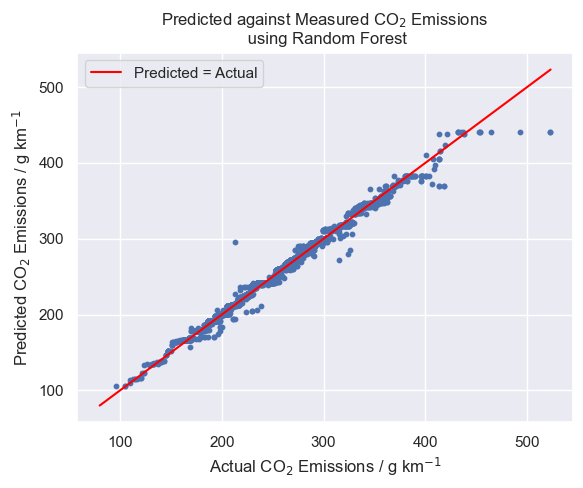

In [28]:
plot_pred_actual(pred, actual, "Random Forest", "pred_act_rf_all.png")

In [29]:
y = co2_enc["co2"]
X = co2_enc.drop(columns=["co2", "fuel_cons_comb", "fuel_cons_comb_mpg"])

pred, actual = pred_rf(X, y, "tree_no_fuel.png")

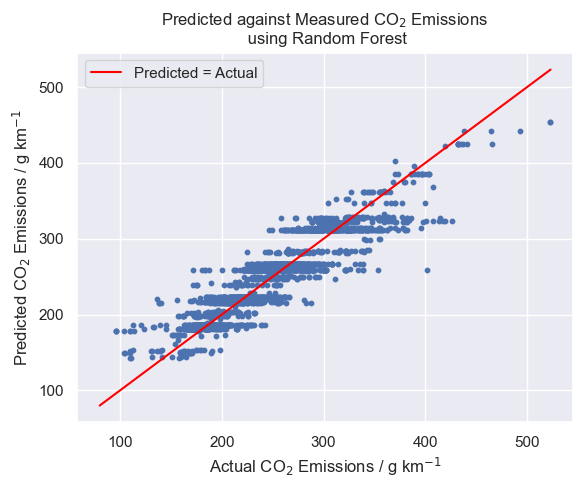

In [30]:
plot_pred_actual(pred, actual, "Random Forest", "pred_act_rf_no_cons.png")